Loading BokehJS ...

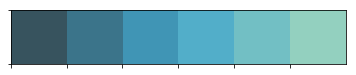

In [1]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-colorblind')
sns.palplot(sns.color_palette("GnBu_d"))

import numpy as np
import scipy.special

from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook

output_notebook()

import os
import numpy as np
import pandas as pd
import graphviz
from numpy import sort
from pprint import pprint
from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

## Methods

In [2]:
def default_exclusion():
    return ['page_id', 
            'page', 
            'category', 
            'user', 
            'label', 
            'content_token_edit_count_avg', 
            'content_token_vs_stop_words']

def optimized_model_exclusion():
    exclusion = default_exclusion()
#     exclusion.extend(['edit_period_q4'])
    return exclusion

def full_model_exclusion():
    return default_exclusion()

def generalized_model_exclusion():
    exclusion = default_exclusion()
    exclusion.extend(['page_talk_edits',
                        'tenure',
                        'ns1_edit_dist',
                        'ns2_edit_dist',
                        'ns3_edit_dist',
                        'ns4_edit_dist',
                        'ns5_edit_dist',
                        'ns6_edit_dist',
                        'ns7_edit_dist',
                        'ns8_edit_dist',
                        'ns9_edit_dist',
                        'ns10_edit_dist',
                        'ns11_edit_dist',
                        'ns12_edit_dist',
                        'ns13_edit_dist',
                        'ns14_edit_dist',
                        'ns15_edit_dist',
                        'total_edited_pages'])

    
    return exclusion
    
def economical_model_exclusion():
    exclusion = default_exclusion()
    exclusion.extend(['edit_type_a',
                        'edit_type_b',
                        'edit_type_c',
                        'edit_type_d',
                        'edit_type_e',
                        'edit_type_f',
                        'edit_type_g',
                        'edit_type_h',
                        'edit_type_i',
                        'edit_type_j',
                        'edit_type_k',
                        'edit_type_l',
                        'edit_type_m',
                        'avg_persistence',
                        'persistence_exists'])
    return exclusion 

def show_importance(model, X_train):
    print('show_importance')
    names = X_train.columns
    sorted_feature_importances = sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), names), reverse=True)
    sorted_features = [feature for importance, feature in sorted_feature_importances]
    sorted_importances = [importance for importance, feature in sorted_feature_importances]

    f1, ax1 = plt.subplots(figsize=(15, 12))
    sns.barplot(y=sorted_features, x=sorted_importances, ax=ax1)

    fig = plt.figure()
    fig.set_size_inches(20,20)
    sns.heatmap(X_train.corr())
    
def cross_validation(classifier, x, y, cv):
    print(type(classifier).__name__)
    results = cross_val_score(classifier, x, y, cv=cv)
    
    print(results)
    print('Accuracy: %.3f%%' % (results.mean()))
    print('Precision: %.3f%%' % (cross_val_score(classifier, x, y, scoring='precision', cv=cv).mean())) 
    print('Recall: %.3f%%' % (cross_val_score(classifier, x, y, scoring='recall', cv=cv).mean()))
    print('F1: %.3f%%' % (cross_val_score(classifier, x, y, scoring='f1', cv=cv).mean()))
    print('ROC AUC: %.3f%%' % (cross_val_score(classifier, x, y, scoring='roc_auc', cv=cv).mean()))
    print('\n')
    
def validate_ip(s):
    a = str(s).split('.')
    if len(a) != 4:
        return False
    for x in a:
        if not x.isdigit():
            return False
        i = int(x)
        if i < 0 or i > 255:
            return False
    return True

## Train/Test Split and Final Evaluation

In [3]:
train_path = r'data/new_train_1000.csv'
test_path = r'data/new_test_1000.csv'

train = pd.read_csv(train_path, header=0)
test = pd.read_csv(test_path, header=0)

x_train = train.drop(generalized_model_exclusion(), axis=1)
y_train = train.label

x_test = test.drop(generalized_model_exclusion(), axis=1)
y_test = test.label

In [8]:
print(f'SMEs: {len(train[train.label==1])}')
print(f'Unknowns: {len(train[train.label==0])}')

SMEs: 488
Unknowns: 497


In [8]:
if 'edit_type_exists' in x_train.columns:
    x_train.drop(['edit_type_exists'], axis=1, inplace=True)
edit_types = [col for col in x_train.columns if str(col).startswith('edit_type')]
print(edit_types)
for edit_type in edit_types:
    x_train[edit_type].fillna(value=-1, inplace=True)  

['edit_type_a', 'edit_type_b', 'edit_type_c', 'edit_type_d', 'edit_type_e', 'edit_type_f', 'edit_type_g', 'edit_type_h', 'edit_type_i', 'edit_type_j', 'edit_type_k', 'edit_type_l', 'edit_type_m']


In [6]:
print(x_train.columns)

Index(['page_edits', 'page_edits_ratio', 'edit_period_q1', 'edit_period_q2',
       'edit_period_q3', 'edit_period_q4', 'mean_edit_interval',
       'mean_edit_size', 'edit_type_a', 'edit_type_b', 'edit_type_c',
       'edit_type_d', 'edit_type_e', 'edit_type_f', 'edit_type_g',
       'edit_type_h', 'edit_type_i', 'edit_type_j', 'edit_type_k',
       'edit_type_l', 'edit_type_m', 'gender', 'ns0_edit_dist',
       'page_edit_dist', 'links_overlap', 'categories_overlap',
       'title_similarity', 'summary_similarity', 'avg_persistence',
       'content_token_count', 'content_token_vs_token',
       'contribution_similarity', 'persistence_exists'],
      dtype='object')


In [9]:
if 'edit_type_exists' in x_test.columns:
    x_test.drop(['edit_type_exists'], axis=1, inplace=True)
edit_types = [col for col in x_test.columns if str(col).startswith('edit_type')]
print(edit_types)
for edit_type in edit_types:
    x_test[edit_type].fillna(value=-1, inplace=True)  

['edit_type_a', 'edit_type_b', 'edit_type_c', 'edit_type_d', 'edit_type_e', 'edit_type_f', 'edit_type_g', 'edit_type_h', 'edit_type_i', 'edit_type_j', 'edit_type_k', 'edit_type_l', 'edit_type_m']


In [10]:
print(x_test.columns)

Index(['page_edits', 'page_edits_ratio', 'edit_period_q1', 'edit_period_q2',
       'edit_period_q3', 'edit_period_q4', 'mean_edit_frequency',
       'mean_edit_size', 'median_edit_size', 'edit_type_a', 'edit_type_b',
       'edit_type_c', 'edit_type_d', 'edit_type_e', 'edit_type_f',
       'edit_type_g', 'edit_type_h', 'edit_type_i', 'edit_type_j',
       'edit_type_k', 'edit_type_l', 'edit_type_m', 'gender', 'ns0_edit_dist',
       'page_edit_dist', 'avg_persistence', 'content_token_count',
       'content_token_vs_token', 'persistence_exists', 'title_similarity',
       'summary_similarity', 'categories_overlap', 'links_overlap',
       'contribution_similarity'],
      dtype='object')


In [11]:
x_test = x_test[x_train.columns]

In [12]:
classifier=XGBClassifier(objective='binary:logistic')
classifier.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [13]:
probabilities = classifier.predict_proba(x_test)

df = pd.DataFrame(probabilities, index=x_test.index)
df = pd.concat([x_test, df], axis=1)
df = df.rename(columns = {1:'expert'})
df = df.rename(columns = {0:'non-expert'})
df['category'] = test['category']
df['page'] = test['page']
df['page_id'] = test['page_id']
df['user'] = test['user']
df['label'] = test['label']
df['registered'] = df['user'].apply(lambda x: not validate_ip(x))
df.sort_values(['expert'], ascending=False).to_csv('data/new_output_1000.csv')
# pd.to_pickle(path='data/new_output_final.bz2', compression='bz2', obj=df.sort_values(['expert'], ascending=False))
df.head(10)

,page_edits,page_edits_ratio,edit_period_q1,edit_period_q2,edit_period_q3,edit_period_q4,mean_edit_frequency,mean_edit_size,median_edit_size,edit_type_a,...,links_overlap,contribution_similarity,non-expert,expert,category,page,page_id,user,label,registered
0,0.010363,0.000907,0.125,0.8125,0.0,0.0625,9.057460e-02,0.087280,0.086358,-1.0,...,-1.000000,-1.0,0.078169,0.921831,Culture,Anarchism,12,-1,NaN,True
1,0.000648,0.000057,0.000,1.0000,0.0,0.0000,0.000000e+00,0.052184,0.052184,0.0,...,0.004378,0.0,0.626283,0.373717,Culture,Anarchism,12,...---...SOS,NaN,True
2,0.000648,0.000057,1.000,0.0000,0.0,0.0000,0.000000e+00,0.007147,0.007147,0.0,...,0.003536,0.0,0.782913,0.217087,Culture,Anarchism,12,0,NaN,True
3,0.000648,0.000057,0.000,0.0000,0.0,1.0000,0.000000e+00,0.155764,0.155764,0.0,...,0.022629,0.0,0.265416,0.734584,Culture,Anarchism,12,1.36.116.199,NaN,False
4,0.003886,0.000340,0.000,1.0000,0.0,0.0000,4.269700e-07,0.080116,0.080138,0.0,...,0.003947,0.0,0.730358,0.269642,Culture,Anarchism,12,100110100,NaN,True
5,0.000648,0.000057,0.000,0.0000,0.0,1.0000,0.000000e+00,0.149569,0.149569,0.0,...,0.004689,0.0,0.488287,0.511713,Culture,Anarchism,12,107.10.236.42,NaN,False
6,0.000648,0.000057,0.000,0.0000,0.0,1.0000,0.000000e+00,0.148484,0.148484,0.0,...,0.000000,0.0,0.400978,0.599022,Culture,Anarchism,12,107.185.24.235,NaN,False
7,0.001295,0.000113,0.000,0.0000,0.0,1.0000,5.008932e-06,0.155652,0.155652,0.0,...,0.088050,0.0,0.210536,0.789464,Culture,Anarchism,12,107.77.210.129,NaN,False
8,0.000648,0.000057,0.000,0.0000,0.0,1.0000,0.000000e+00,0.147736,0.147736,0.0,...,0.000000,0.0,0.432160,0.567840,Culture,Anarchism,12,108.244.152.145,NaN,False
9,0.000648,0.000057,0.000,0.0000,1.0,0.0000,0.000000e+00,0.134327,0.134327,0.0,...,0.000000,0.0,0.416065,0.583935,Culture,Anarchism,12,108.25.196.11,NaN,False


In [74]:
test[test.user == 'Coasterlover1994'][['user', 'page']]

,user,page
8942,Coasterlover1994,A
89981,Coasterlover1994,Apple Inc.
101940,Coasterlover1994,Atom
135792,Coasterlover1994,Arachnophobia
215430,Coasterlover1994,Statue of Zeus at Olympia
226117,Coasterlover1994,Recycling
253949,Coasterlover1994,Lymphatic system
255993,Coasterlover1994,Hepatitis C
276944,Coasterlover1994,Non-renewable resource
312695,Coasterlover1994,Steven Tyler


In [64]:
registered = df[df.registered]
unregistered = df[~df.registered]
print(f'Total registered pairs: {len(registered)}')
print(f'Total unregistered pairs: {len(unregistered)}')
print(f'Total registered users: {len(registered.user.unique())}')
print(f'Total unregistered users: {len(unregistered.user.unique())}')

Total registered pairs: 230200
Total unregistered pairs: 226655
Total registered users: 91558
Total unregistered users: 213841


In [65]:
print(f'Total registered SMEs pairs: {len(registered[registered.expert >= 0.8])}')
print(f'Total unregistered SMEs pairs: {len(unregistered[unregistered.expert >= 0.8])}')

Total registered SMEs pairs: 41975
Total unregistered SMEs pairs: 41092


In [67]:
print(f'Total registered SME users: {len(registered[registered.expert >= 0.8].user.unique())}')
print(f'Total unregistered SME users: {len(unregistered[unregistered.expert >= 0.8].user.unique())}')

Total registered SME users: 21299
Total unregistered SME users: 40825


In [69]:
print(f'Registered SMEs ratio: {len(registered[registered.expert >= 0.8].user.unique())/len(registered.user.unique())}')
print(f'Unregistered SMEs ratio: {len(unregistered[unregistered.expert >= 0.8].user.unique())/len(unregistered.user.unique())}')

Registered SMEs ratio: 0.23262849778282618
Unregistered SMEs ratio: 0.19091287451891825


In [14]:
df = df.sort_values(['expert'])

thresholds = list(range(75, 100, 1))

cols = ['threshold', 
        '#<user,page>', 
        '# of distinct users', 
        '%<user,page> of total population', 
        'page edits (mean)', 
        'page edits (count)',
        'total page edits (#revisions)']
rows = []
for threshold in thresholds:
    threshold_str = '{}%'.format(threshold)
    threshold = threshold / 100
    
    unique_users_above_threshold = len(df[df.expert > threshold]['user'].unique())
    user_page_pairs_above_threshold = len(df[df.expert > threshold])
    total_user_page_pairs = len(df)
    page_edit_mean_above_threshold = np.round(np.average(df[df.expert > threshold]['page_edits']), 2)
    total_page_edits_above_threshold = np.round(np.sum(df[df.expert > threshold]['page_edits']), 2)
    total_page_edits = np.round(np.sum(df['page_edits']), 2)
                       
    rows.append([threshold_str,
                 user_page_pairs_above_threshold,
                 unique_users_above_threshold,
                 user_page_pairs_above_threshold / total_user_page_pairs,
                 page_edit_mean_above_threshold,
                 total_page_edits_above_threshold,
                 total_page_edits])

ndf = pd.DataFrame(rows, columns=cols)
ndf.to_csv('data/new_test_stats_1000_articles.csv')
ndf.head(25)

/home/yarov/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/yarov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,threshold,"#<user,page>",# of distinct users,"%<user,page> of total population",page edits (mean),page edits (count),total page edits (#revisions)
0,75%,122042,97476,0.267135,0.0,223.66,646.06
1,76%,113150,89193,0.247672,0.0,211.37,646.06
2,77%,105576,82273,0.231093,0.0,199.78,646.06
3,78%,97530,75000,0.213481,0.0,187.66,646.06
4,79%,90209,68357,0.197457,0.0,175.63,646.06
5,80%,83066,62123,0.181821,0.0,162.23,646.06
6,81%,76298,56214,0.167007,0.0,148.44,646.06
7,82%,70160,51009,0.153572,0.0,134.86,646.06
8,83%,63900,45515,0.139869,0.0,123.04,646.06
9,84%,58330,40516,0.127677,0.0,112.66,646.06


In [46]:
print(f'75%: {223/646.06}')
print(f'80%: {162.23/646.06}')
print(f'85%: {101.73/646.06}')

75%: 0.3451691793331889
80%: 0.2511067083552611
85%: 0.15746215521778165


In [15]:
page_edit_thresholds = list(range(1, 6, 1))
print('expertise probability > 80%')

pe_cols = ['page edits threshold', 'pairs above threshold', 'total pairs > 80%', 'total pairs', 'a', 'b']
pe_rows = []
for page_edit_threshold in page_edit_thresholds:
    
    page_edits_above_80_and_threshold = len(df[(df.expert > 0.8) & (df.page_edits > page_edit_threshold)])
    page_edits_above_80 = len(df[df.expert > 0.8])
    page_edits = len(df[df.page_edits > page_edit_threshold])
    a = np.round(np.sum(df[(df.page_edits > page_edit_threshold)]['page_edits']), 2)
    b = np.round(np.sum(df[(df.expert > 0.8) & (df.page_edits > page_edit_threshold)]['page_edits']), 2)
    
    pe_rows.append([page_edit_threshold, 
                    page_edits_above_80_and_threshold, 
                    page_edits_above_80,
                    page_edits, a, b])

pe_df = pd.DataFrame(pe_rows, columns=pe_cols)
pe_df.head()
pe_df.to_csv('data/new_test_page_edit_stats_1000_articles.csv')

expertise probability > 80%


In [16]:
def get_category_row(data, category):
    row=[]
    row.append(category)
    row.append(len(data[(data.category==category) & (data.expert >= .0) & (data.expert < .1)]))
    row.append(len(data[(data.category==category) & (data.expert >= .1) & (data.expert < .2)]))
    row.append(len(data[(data.category==category) & (data.expert >= .2) & (data.expert < .3)]))
    row.append(len(data[(data.category==category) & (data.expert >= .3) & (data.expert < .4)]))
    row.append(len(data[(data.category==category) & (data.expert >= .4) & (data.expert < .5)]))
    row.append(len(data[(data.category==category) & (data.expert >= .5) & (data.expert < .6)]))
    row.append(len(data[(data.category==category) & (data.expert >= .6) & (data.expert < .7)]))
    row.append(len(data[(data.category==category) & (data.expert >= .7) & (data.expert < .8)]))
    row.append(len(data[(data.category==category) & (data.expert >= .8) & (data.expert < .9)]))
    row.append(len(data[(data.category==category) & (data.expert >= .9)]))
    return row
 
rows = []
categories = df.category.unique()
for c in categories:
    if not pd.isnull(c):
        rows.append(get_category_row(df, c))

categories_df = pd.DataFrame(rows, columns=['category', 
                                            '0.0 - 0.1',
                                            '0.1 - 0.2',
                                            '0.2 - 0.3',
                                            '0.3 - 0.4',
                                            '0.4 - 0.5',
                                            '0.5 - 0.6',
                                            '0.6 - 0.7',
                                            '0.7 - 0.8',
                                            '0.8 - 0.9',
                                            '0.9 - 1.0'])
print(categories_df.head(25))
categories_df.to_csv('data/new_categories_count_gm.csv', index=False)



ratio_rows = []
for c in categories:
    if not pd.isnull(c):
        res = categories_df[categories_df.category == c][['0.0 - 0.1',
                                                          '0.1 - 0.2',
                                                          '0.2 - 0.3',
                                                          '0.3 - 0.4',
                                                          '0.4 - 0.5',
                                                          '0.5 - 0.6',
                                                          '0.6 - 0.7',
                                                          '0.7 - 0.8',
                                                          '0.8 - 0.9',
                                                          '0.9 - 1.0']]
        # get the category values
        c_values = list(res.iloc[0])
        # calculate sum of the category values
        c_sum = res.iloc[0].sum()
        # prepare array for the ratio result
        row = [c]
        for c_val in c_values:
            row.append(c_val / c_sum)
        ratio_rows.append(row)
        
category_ratio_df = pd.DataFrame(ratio_rows, columns=['category', '0.0 - 0.1',
                                                        '0.1 - 0.2',
                                                        '0.2 - 0.3',
                                                        '0.3 - 0.4',
                                                        '0.4 - 0.5',
                                                        '0.5 - 0.6',
                                                        '0.6 - 0.7',
                                                        '0.7 - 0.8',
                                                        '0.8 - 0.9',
                                                        '0.9 - 1.0'])

category_ratio_df.to_csv('data/new_categories_ratio_gm.csv', index=False)

       category  0.0 - 0.1  0.1 - 0.2  0.2 - 0.3  0.3 - 0.4  0.4 - 0.5  \
0   Environment       2031       1598       1280       1535       1938   
1      Politics       1739       1186       1171       1350       1928   
2       History       1668       1258       1156       1261       1640   
3        People       1283        834        765        859       1205   
4     Geography       1573       1011       1119       1214       1552   
5      Language       1506       1131       1098       1349       1663   
6          Life       1325       1119       1048       1224       1487   
7      Concepts       1853       1815       1624       1754       2189   
8       Science       1983       1505       1482       1748       2331   
9        Health       1498       1049        998       1079       1442   
10       Nature       1979       1636       1427       1512       1802   
11    Education       1304       1116        973       1032       1363   
12   Humanities        997        611 

In [17]:
def get_category_row(data, category):
    row=[]
    row.append(category)
    cat_exp_80_90 = data[(data.category==category) & (data.expert >= .8) & (data.expert < .9)]
    row.append(len(cat_exp_80_90[cat_exp_80_90.registered]))
    row.append(len(cat_exp_80_90[~cat_exp_80_90.registered]))
    
    cat_exp_90_100 = data[(data.category==category) & (data.expert >= .9) & (data.expert < 1.)]
    row.append(len(cat_exp_90_100[cat_exp_90_100.registered]))
    row.append(len(cat_exp_90_100[~cat_exp_90_100.registered]))
    return row

rows = []
categories = df.category.unique()
for c in categories:
    if not pd.isnull(c):
        rows.append(get_category_row(df, c))

reg_vs_unreg_df = pd.DataFrame(rows, columns=['category', 
                                              'registered (0.8 - 0.9)',
                                              'unregistered (0.8 - 0.9)', 
                                              'registered (0.9 - 1.0)',
                                              'unregistered (0.9 - 1.0)'])
reg_vs_unreg_df.head()
reg_vs_unreg_df.to_csv('data/new_registered_vs_unregistered_80-100.csv', index=False)

In [ ]:
# bins_count = 10
# fig, ax = plt.subplots(figsize=(15,10))
# bins = plt.hist(df[df.category == 'Medicine'].expert, bins=bins_count, alpha=0.5, label='Expert editors')
# plt.legend(loc='upper right')

# for i in range(bins_count):
#     plt.text(bins[1][i], bins[0][i], str(bins[0][i]))

In [23]:
from scipy.stats import pearsonr

drop_columns = default_exclusion()
drop_columns.extend(['expert', 'non-expert', 'registered', 'persistence_exists'])

rows = []
temp_df = pd.DataFrame(df, index=df.index)

for drop_col in drop_columns:
    if drop_col in temp_df.columns:
        temp_df = temp_df.drop(drop_col, axis=1)

columns = list(temp_df.columns)

for column in columns:
    row = []
    r, prob = pearsonr(df['expert'], df[column])    
#     if r > 0:
#         print('Positive correlation: r = %.3f p-value = %.3f' % (r, prob))
#     elif r < 0:
#         print('Negative correlation: r = %.3f p-value = %.3f' % (r, prob))
#     else:
#         print('No correlation: r = %.3f p-value = %.3f' % (r, prob))
    row.extend([column, '%.3f' % (r), prob])
    rows.append(row)

corr_df = pd.DataFrame(rows, columns=['column', 'correlation coefficient', 'p-value'])
corr_df.head()
corr_df.to_csv('data/new_correlation_coefficient_gm.csv', index=False)

In [ ]:
# print('----------------- Generalized model -----------------')

# sns.set(style="white", color_codes=True)
# g = sns.jointplot(x="expert", y="ns0_edit_dist", data=df[df.registered])

In [ ]:
# sorted_result = df.sort_values(['expert'], ascending=False)
# bins_count = 100
# fig, ax = plt.subplots(figsize=(15,10))
# reg_bins = plt.hist(sorted_result.expert, bins=bins_count, alpha=0.5, label='Expert editors')
# plt.legend(loc='upper right')

In [ ]:
# sorted_result = df.sort_values(['expert'], ascending=False)
# bins_count = 10
# fig, ax = plt.subplots(figsize=(15,10))
# bins = plt.hist(sorted_result.expert, bins=bins_count, alpha=0.5, label='Expert editors')
# plt.legend(loc='upper right')

# for i in range(bins_count):
#     plt.text(bins[1][i], bins[0][i], str(bins[0][i]))

ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

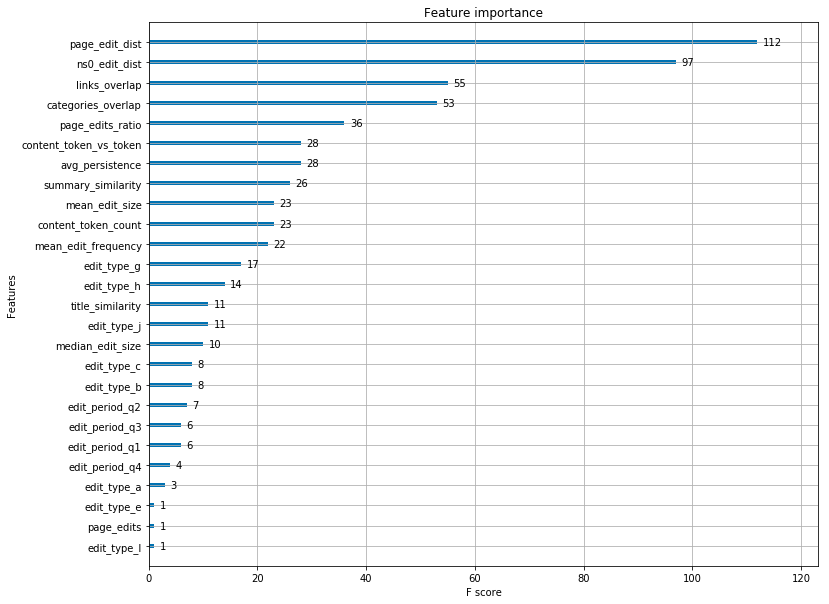

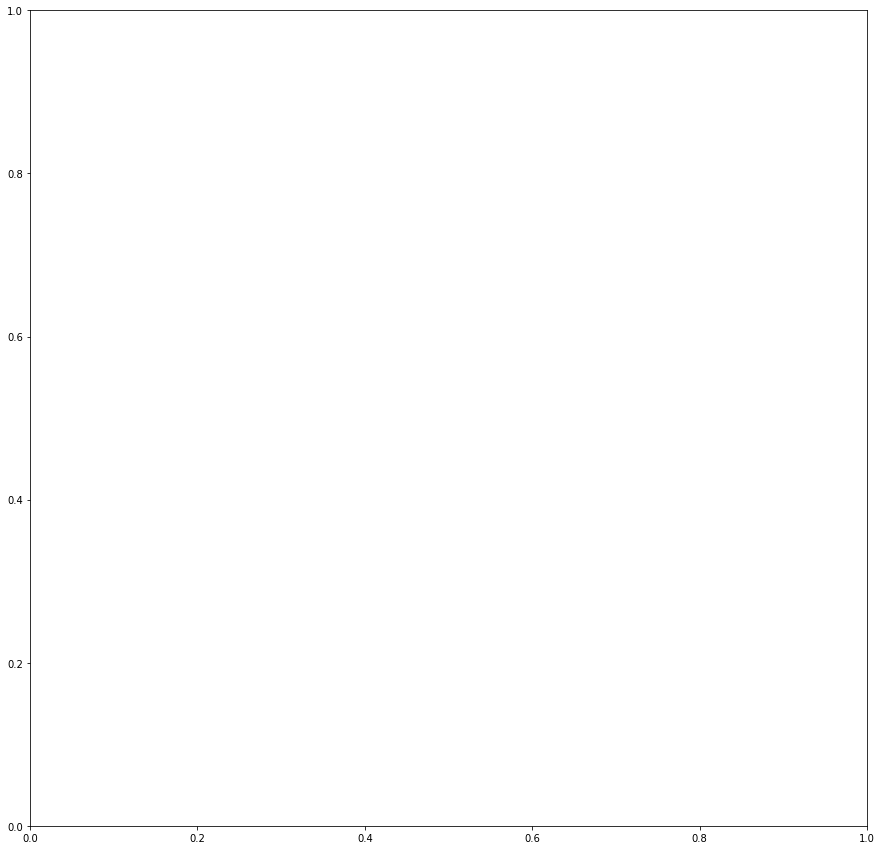

In [21]:
model = XGBClassifier(objective='binary:logistic')
model.fit(x_train, y_train)
fig, ax = plt.subplots(figsize=(12,10))
plot_importance(model, ax=ax)

fig, ax = plt.subplots(figsize=(15,15))
plot_tree(model, ax=ax, num_trees=99)

y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
# print("Accuracy: %.3f%%" % (accuracy * 100.0))
# print("Precision: %.3f%%" % (precision * 100.0))

## Cross-Validation Evaluation

In [27]:
dataset = pd.read_csv(train_path, header=0)
print ('Total experts: {}'.format(len(dataset[dataset.label == 1])))
print ('Total non-experts: {}'.format(len(dataset[dataset.label == 0])))

x_train_full = dataset.drop(generalized_model_exclusion(), axis=1)
y_train_full = dataset.label

X = dataset.drop(generalized_model_exclusion(), axis=1)
Y = dataset.label

seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# pprint(x_train_full.columns)

Total experts: 488
Total non-experts: 497


In [34]:
kfold = StratifiedKFold(n_splits=10, random_state=7)
# kfold = KFold(n_splits=10, random_state=7)
model = XGBClassifier(objective='binary:logistic', 
                      random_state=13, 
                      max_depth=7,
                      n_estimators=200)
cross_validation(classifier=model, x=x_train_full, y=y_train_full, cv=kfold)

XGBClassifier
[0.7979798  0.72727273 0.80808081 0.80808081 0.7979798  0.75757576
 0.78787879 0.81632653 0.70103093 0.78350515]
Accuracy: 0.779%
Precision: 0.765%
Recall: 0.799%
F1: 0.780%
ROC AUC: 0.855%




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=13, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
Accuracy: 76.65%
Precision: 77.31%
Recall: 82.88%
F1: 80.00%
ROC AUC: 75.74%


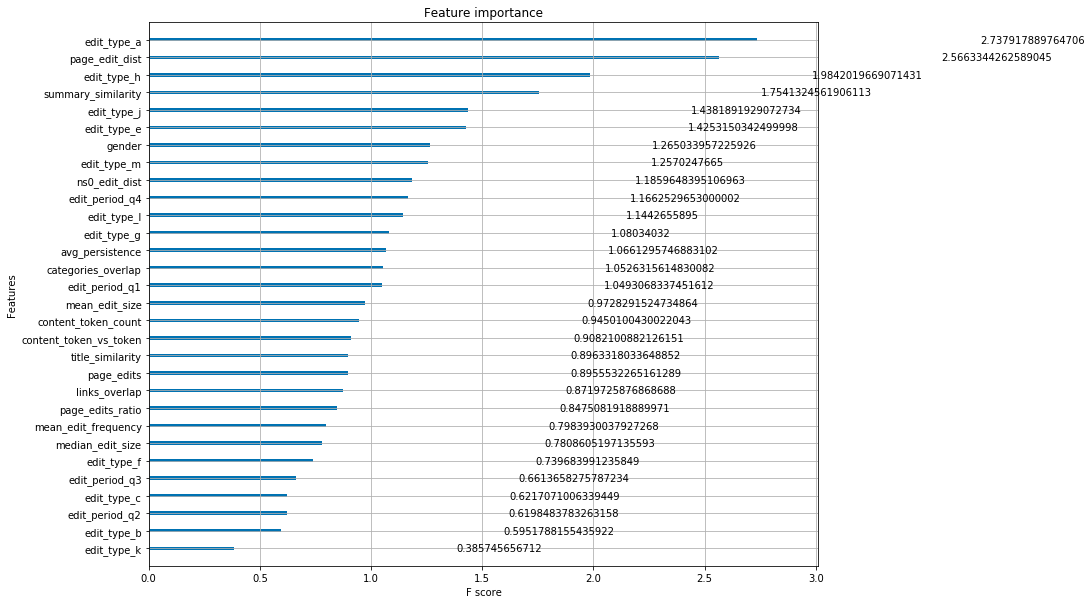

In [36]:
# fit model no training data
model = XGBClassifier(objective='binary:logistic', 
                      random_state=13, 
                      max_depth=7,
                      n_estimators=200)
model.fit(X_train, y_train)
print(model)


# make predictions for test data
predictions = model.predict(X_test)

# evaluate predictions
print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions) * 100.0))
print('Precision: %.2f%%' % (precision_score(y_test, predictions) * 100.0))
print('Recall: %.2f%%' % (recall_score(y_test, predictions) * 100.0))
print('F1: %.2f%%' % (f1_score(y_test, predictions) * 100.0))
print('ROC AUC: %.2f%%' % (roc_auc_score(y_test, predictions) * 100.0))

# show_importance(model, X_train)
fig, ax = plt.subplots(figsize=(12,10))
plot_importance(model, ax=ax, importance_type='gain')

## Less Accurate Models 

In [38]:
model = GradientBoostingClassifier(max_depth=7,#22
                                   n_estimators = 162,#162
                                   max_features = "log2",
                                   learning_rate = 0.1,#0.05
                                   min_samples_leaf = 2,
                                   criterion = "mse")
model.fit(X_train, y_train)
print(model)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions) * 100.0))
print('Precision: %.2f%%' % (precision_score(y_test, predictions) * 100.0))
print('Recall: %.2f%%' % (recall_score(y_test, predictions) * 100.0))
print('F1: %.2f%%' % (f1_score(y_test, predictions) * 100.0))
print('ROC AUC: %.2f%%' % (roc_auc_score(y_test, predictions) * 100.0))

# show_importance(model, X_train)

GradientBoostingClassifier(criterion='mse', init=None, learning_rate=0.1,
              loss='deviance', max_depth=7, max_features='log2',
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=2,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=162, n_iter_no_change=None, presort='auto',
              random_state=None, subsample=1.0, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Accuracy: 75.63%
Precision: 77.39%
Recall: 80.18%
F1: 78.76%
ROC AUC: 74.97%


In [39]:
model = RandomForestClassifier(max_depth=7, n_estimators = 200, max_features = 'sqrt')
model.fit(X_train, y_train)
print(model)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions) * 100.0))
print('Precision: %.2f%%' % (precision_score(y_test, predictions) * 100.0))
print('Recall: %.2f%%' % (recall_score(y_test, predictions) * 100.0))
print('F1: %.2f%%' % (f1_score(y_test, predictions) * 100.0))
print('ROC AUC: %.2f%%' % (roc_auc_score(y_test, predictions) * 100.0))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy: 74.11%
Precision: 78.85%
Recall: 73.87%
F1: 76.28%
ROC AUC: 74.15%


In [19]:
!pip install graphviz

In [50]:
train[train['user']=='EdwardBetts']

,page_id,user,page_edits,page_edits_ratio,page_talk_edits,edit_period_q1,edit_period_q2,edit_period_q3,edit_period_q4,mean_edit_frequency,...,content_token_vs_token,persistence_exists,title_similarity,summary_similarity,categories_overlap,links_overlap,contribution_similarity,label,page,category
